In [1]:
%matplotlib inline


#essentials
import numpy as np
import pylab as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import healpy as hp
from datetime import datetime
from pygdsm import GlobalSkyModel
from pygdsm import GSMObserver


#non essential
import time
from tqdm import tqdm
from astropy.coordinates import Angle
import numpy.ma as ma

# Quick Plot

### haslam as basemap

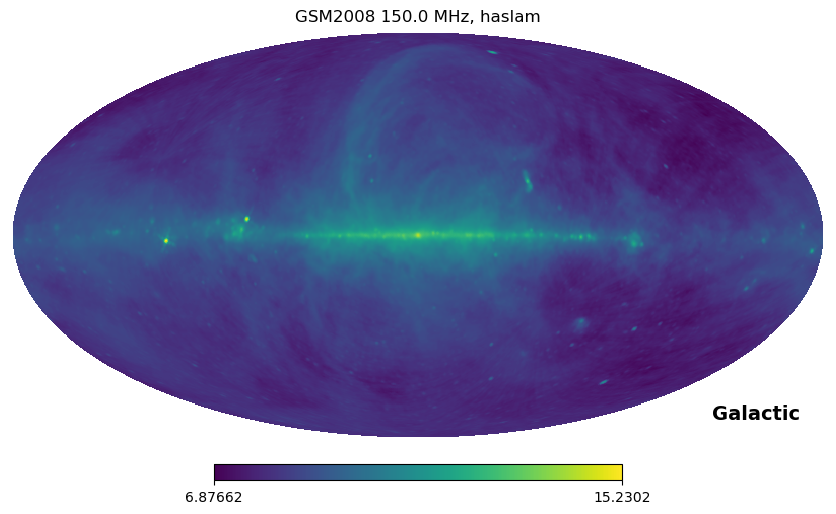

In [8]:
gsm = GlobalSkyModel(interpolation='cubic', basemap='haslam')

freq = 150 # MHz unit
gsm.generate(freq)  
gsm.view(logged=True)

### wmap as basemap

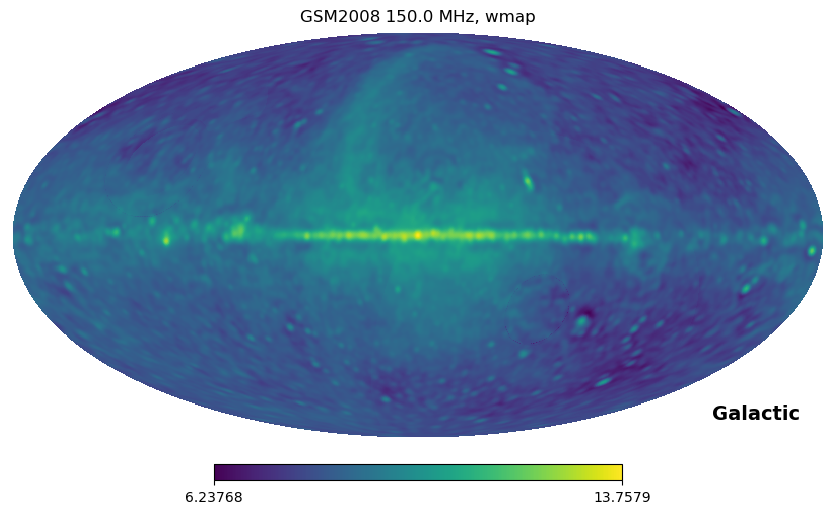

In [5]:
gsm = GlobalSkyModel(freq_unit='MHz', interpolation='cubic', basemap='wmap')

freq = 150 # MHz unit
gsm.generate(freq)  
gsm.view(logged=True)

# MollView Array and Spectral Index

In [72]:
gsm = GlobalSkyModel(freq_unit='MHz', interpolation='cubic', basemap='haslam')

### brightness temperature vs freq

In [74]:
map_cube.shape

(100, 3145728)

(100, 3145728)


Text(0, 0.5, 'Temperature [K]')

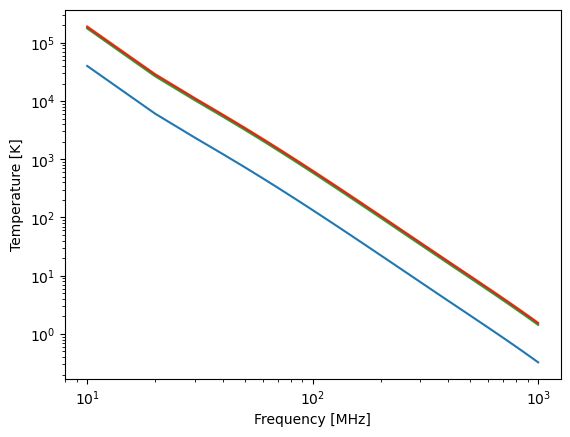

In [77]:
freqs = np.linspace(10, 1000, 100)
map_cube = gsm.generate(freqs)

print(map_cube.shape)
plt.loglog(freqs, map_cube[:,0])
plt.loglog(freqs,map_cube[:,123])
plt.loglog(freqs,map_cube[:,1546])
plt.loglog(freqs,map_cube[:,166])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")

In [80]:
map_cube.shape

(4, 3145728)

## calculating spectral index

In [79]:
freqs = np.array([45,150,408,1420]) #frequencies of map

map_cube = gsm.generate(freqs)

In [12]:
spectral_index_1 = -1*np.log(map_cube[1]/map_cube[0])/np.log(freqs[1]/freqs[0])

In [13]:
spectral_index_2 = -1*np.log(map_cube[3]/map_cube[2])/np.log(freqs[3]/freqs[2])

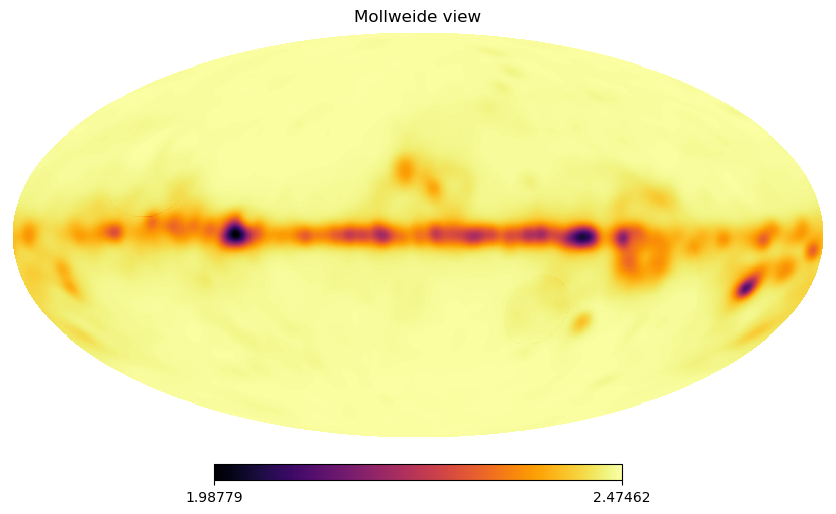

In [81]:
hp.mollview(spectral_index_1,cmap='inferno',norm='log')

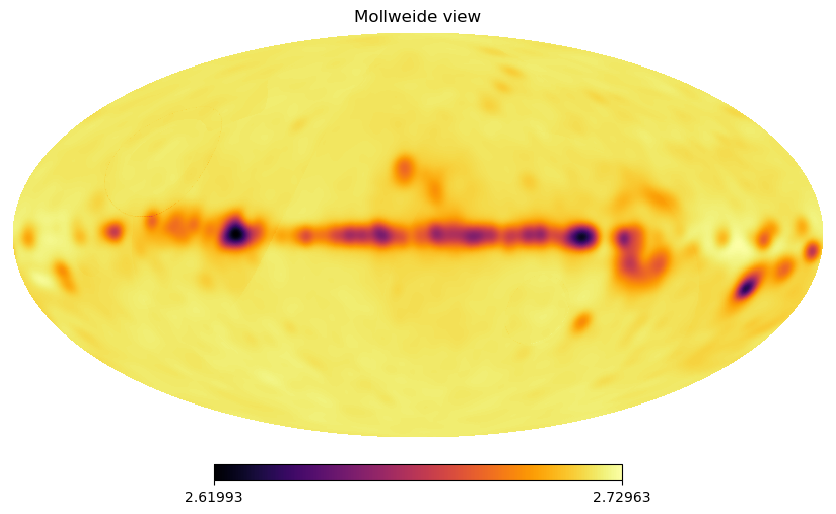

In [82]:
hp.mollview(spectral_index_2,cmap='inferno',norm='log')

# Visible region of the sky

In [83]:
(latitude, longitude, elevation) = ('20.2961', '85.8245', 45) #Bhubaneswar Odisa
ov = GSMObserver()
ov.lon = longitude
ov.lat = latitude
ov.elev = elevation
ov.date = datetime(2023, 6, 12, 17, 30)

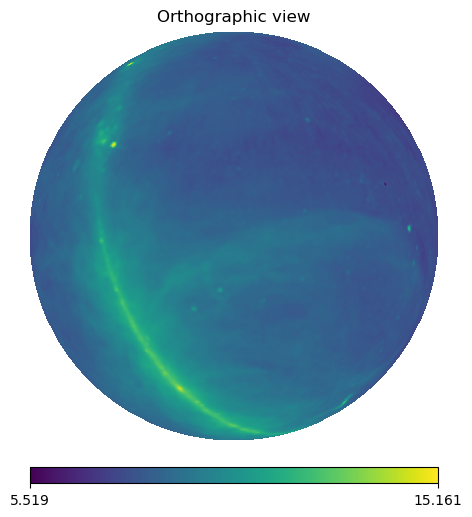

In [84]:
ov.generate(150)
sky_dome_view = ov.view(logged=True)

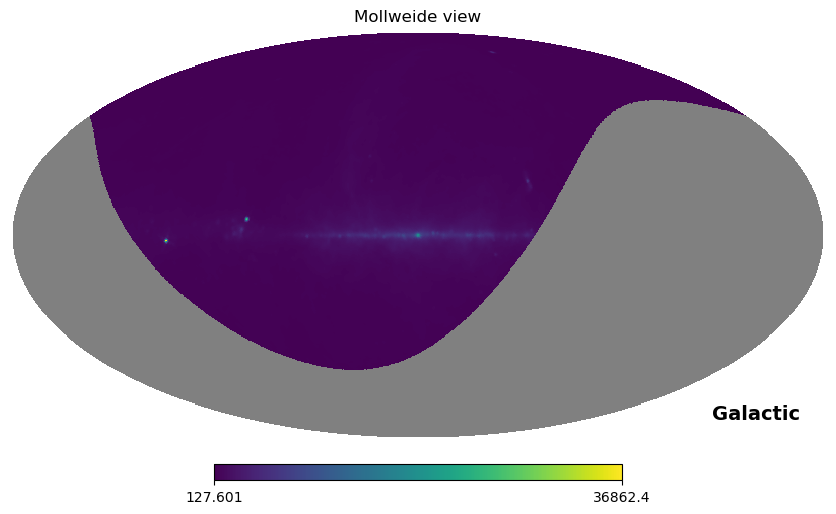

In [87]:
sky_moll_view = ov.view_observed_gsm()

In [44]:
sky_moll_view

masked_array(data=[--, --, --, ..., 758.8432990977827, 778.9286724875276,
                   763.5626661388981],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=-1.6375e+30)

In [24]:
NSIDE=16

low_res_sky = hp.pixelfunc.ud_grade(sky_moll_view,nside_out=NSIDE)

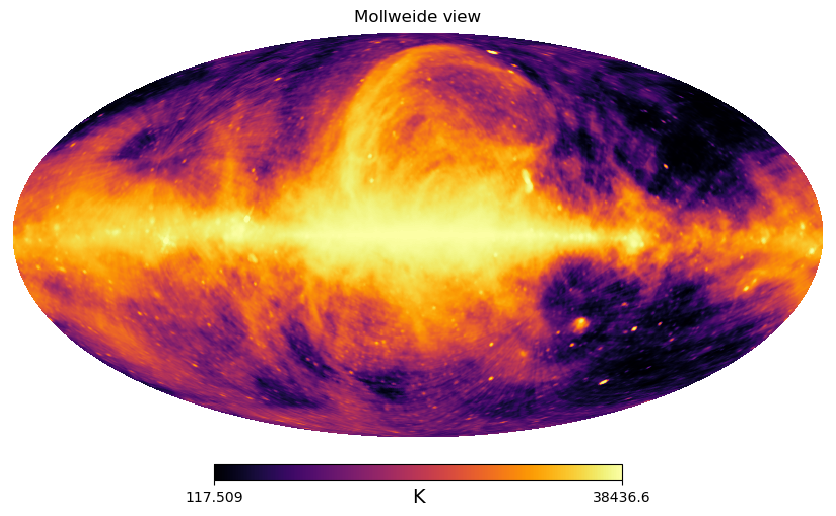

In [39]:
# moll full view
hp.mollview(map_cube[1],cmap='inferno',unit='K',norm='hist')

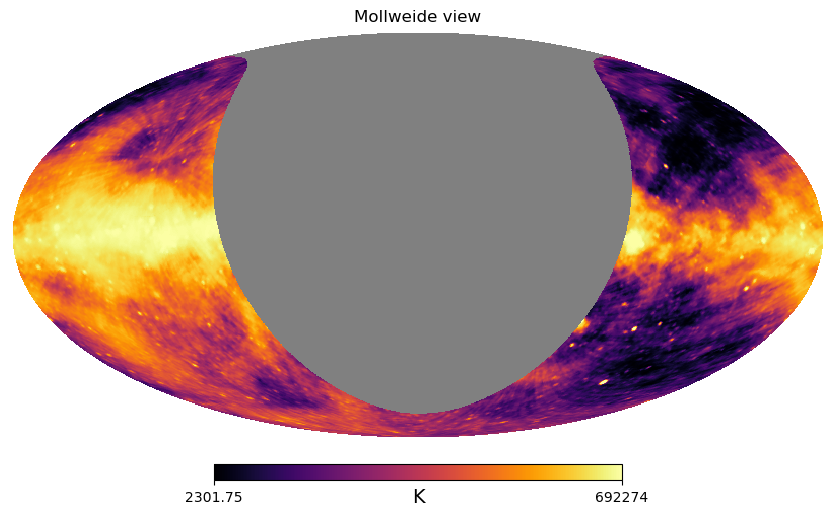

In [25]:
hp.mollview(sky_moll_view,cmap='inferno',unit='K',norm='hist')

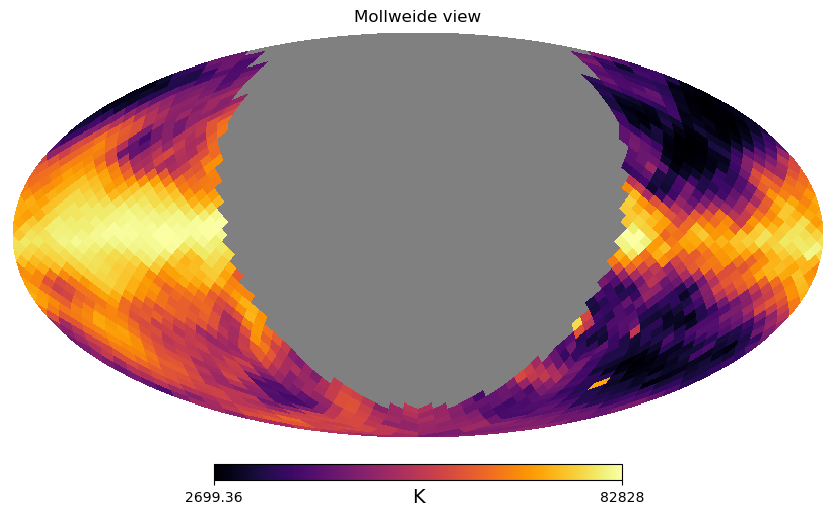

In [27]:
hp.mollview(low_res_sky,cmap='inferno',unit='K',norm='hist')

In [69]:
npix = len(sky_moll_view)

In [70]:
print(f"Angular resolution of the original map: \
{np.degrees(hp.pixelfunc.nside2resol(hp.pixelfunc.npix2nside(npix))):.2f} degrees")
print(f"NSIDE of the original map: {hp.pixelfunc.npix2nside(npix)}")
print(f"Angular resolution: {np.degrees(hp.pixelfunc.nside2resol(NSIDE)):.2f} degrees")
print(f"Number of pixels: {hp.pixelfunc.nside2npix(NSIDE)}")

Angular resolution of the original map: 0.11 degrees
NSIDE of the original map: 512
Angular resolution: 3.66 degrees
Number of pixels: 3072


# Converting converting healpy_pxl_idx to local alt-az

In [28]:
ipix = int(3145728/16)
nside = hp.npix2nside(3145728)
theta, phi = hp.pix2ang(nside, ipix)
ra = np.rad2deg(phi) # ra in degrees in degrees ICRS
dec = np.rad2deg(0.5 * np.pi - theta) # dec in degrees ICRS

print(ra)
print(dec)

12.754777070063694
61.001063143060755


In [29]:
c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
c_icrs.galactic 

<SkyCoord (Galactic): (l, b) in deg
    (122.88113994, -1.87064314)>

In [30]:
(latitude, longitude, elevation) = ('20.2961', '85.8245', 100)
time = datetime(2023, 12, 12, 17, 30)


earth_location = EarthLocation(lat=float(latitude)*u.deg, lon=float(longitude)*u.deg,height=elevation*u.m)
icrs_coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

trans_local = icrs_coord.transform_to(AltAz(obstime=time, location=earth_location))

az, alt                     = trans_local.az.degree, trans_local.alt.degree

print(f'alt:{alt}')
print(f'az:{az}')

alt:33.67979624870707
az:331.1184042672906


# Beam Weighting

In [33]:
mol_view_array = low_res_sky

x = np.where(mol_view_array.mask == False)

nside = hp.npix2nside(len(mol_view_array))

beam_wt_sky = np.zeros_like(mol_view_array)

for i in tqdm(x[0]):
    if mol_view_array.mask[i] == True:
        continue
    ipix = int(i)
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = np.rad2deg(phi) # ra in degrees in degrees galactic coordinate system
    dec = np.rad2deg(0.5 * np.pi - theta) # dec in degrees galactic coordinate system
    
    (latitude, longitude, elevation) = ('20.2961', '85.8245', 100)
    time = datetime(2023, 12, 12, 17, 30)


    earth_location = EarthLocation(lat=float(latitude)*u.deg, lon=float(longitude)*u.deg,height=elevation*u.m)
    icrs_coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

    trans_local = icrs_coord.transform_to(AltAz(obstime=time, location=earth_location))

    az, alt                     = trans_local.az.degree, trans_local.alt.degree
    
    beam_wt_sky[i] = mol_view_array[i] * (np.cos(np.radians(alt))**2)   

100%|██████████████████████████████████████| 1598/1598 [00:04<00:00, 382.30it/s]


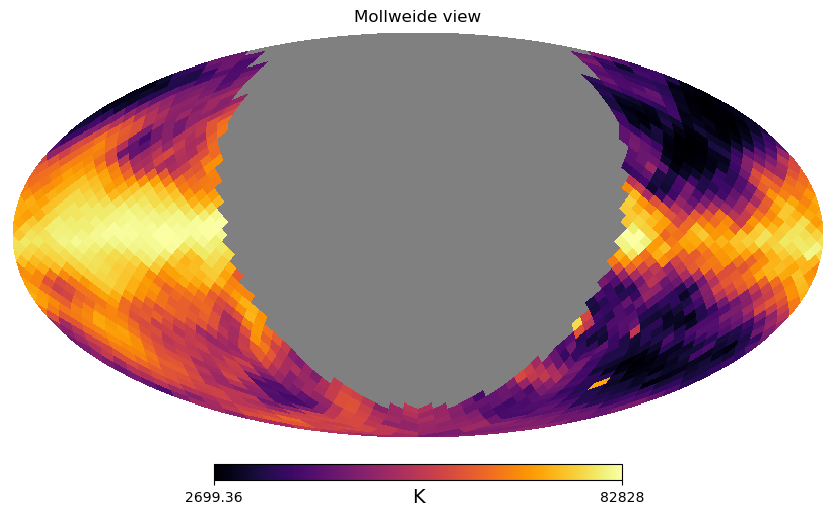

In [34]:
hp.mollview(low_res_sky,cmap='inferno',unit='K',norm='hist')

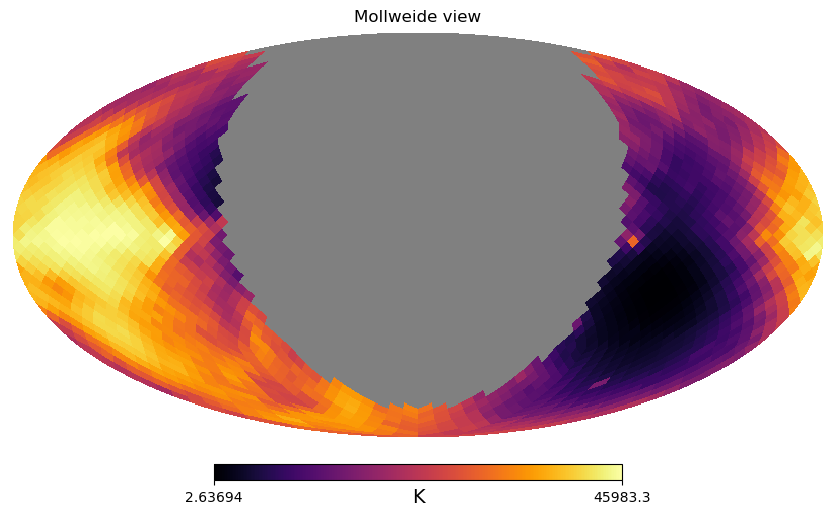

In [35]:
hp.mollview(beam_wt_sky,cmap='inferno',unit='K',norm='hist')

In [37]:
np.mean(beam_wt_sky)

3869.3560555141466

In [40]:
np.mean(low_res_sky)

5822.489761895663

# for beam weighted spectra

In [50]:
%%time

(latitude, longitude, elevation) = ('20.2961', '85.8245', 45) #Bhubaneswar Odisa
ov = GSMObserver()
ov.lon = longitude
ov.lat = latitude
ov.elev = elevation
ov.date = datetime(2023, 12, 12, 17, 30)

spectra = np.zeros(100)
k = 0
for freq in np.linspace(10, 1000, 100):
    ov.generate(freq)
    sky_moll_view = ov.view_observed_gsm()
    plt.close()
    
    NSIDE=16
    low_res_sky = hp.pixelfunc.ud_grade(sky_moll_view,nside_out=NSIDE)
    
    mol_view_array = low_res_sky

    x = np.where(mol_view_array.mask == False)

    nside = hp.npix2nside(len(mol_view_array))

    beam_wt_sky = np.zeros_like(mol_view_array)

    for i in tqdm(x[0]):
        if mol_view_array.mask[i] == True:
            continue
        ipix = int(i)

        theta, phi = hp.pix2ang(nside, ipix)
        ra = np.rad2deg(phi) # ra in degrees in degrees galactic coordinate system
        dec = np.rad2deg(0.5 * np.pi - theta) # dec in degrees galactic coordinate system

        (latitude, longitude, elevation) = ('20.2961', '85.8245', 100)
        time = datetime(2023, 12, 12, 17, 30)


        earth_location = EarthLocation(lat=float(latitude)*u.deg, lon=float(longitude)*u.deg,\
                                       height=elevation*u.m)
        icrs_coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

        trans_local = icrs_coord.transform_to(AltAz(obstime=time, location=earth_location))

        az, alt                     = trans_local.az.degree, trans_local.alt.degree

        beam_wt_sky[i] = mol_view_array[i] * (np.cos(np.radians(alt))**2)
        
    spectra[k] = np.mean(beam_wt_sky) 
    k = k + 1

100%|██████████████████████████████████████| 1598/1598 [00:04<00:00, 390.71it/s]

CPU times: user 10min 22s, sys: 6min 36s, total: 16min 59s
Wall time: 7min 54s


In [57]:
freq_min=40
freq_max=200
freq_array=np.linspace(10,1000,100)
ind_freq = np.logical_and((freq_array>freq_min),(freq_array)<freq_max)
freq_sel = freq_array[ind_freq]
T_sel = spectra[ind_freq]

In [66]:
cc = np.polyfit(np.log10(freq_sel),np.log10(T_sel),3)
ff = 10**np.polyval(cc,np.log10(freq_sel))
res = T_sel - ff

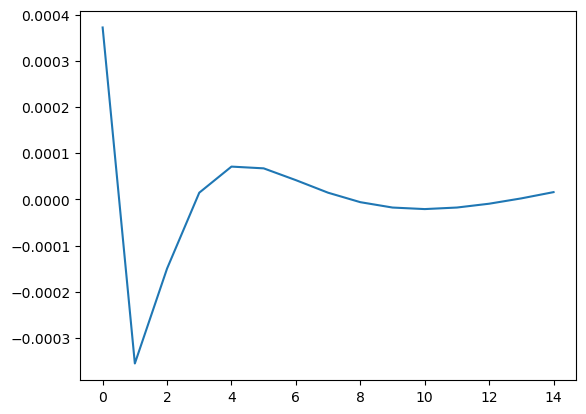

In [67]:
plt.plot(res)